# Movement data analysis

Analyze the movement data collected during the experiment

## Import data and libraries

In [1]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
from branca.colormap import linear
from geolib import geohash as geolib
import json
import math
import random
import arc_drawer
import numpy as np
import pydeck as pdk

/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Defined legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 300px; 
                 background-color: white; border:2px solid grey; z-index:9999; 
                 font-size:14px;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; Walking &nbsp; <i class="fa fa-square" style="color:#7FC97F"></i><br>
     &nbsp; On Bicycle &nbsp; <i class="fa fa-square" style="color:#BDAED4"></i><br>
     &nbsp; Train &nbsp; <i class="fa fa-square" style="color:#FDBF85"></i><br>
     &nbsp; Bus &nbsp; <i class="fa fa-square" style="color:#FFFF99"></i><br>
     &nbsp; Electric Bus &nbsp; <i class="fa fa-square" style="color:#FFFF99"></i><br>
     &nbsp; Car &nbsp; <i class="fa fa-square" style="color:#386CB0"></i><br>
     &nbsp; Tram &nbsp; <i class="fa fa-square" style="color:#F0027F"></i><br>
     &nbsp; Plane &nbsp; <i class="fa fa-square" style="color:#BE5B17"></i><br>
     &nbsp; Boat &nbsp; <i class="fa fa-square" style="color:#BE5B17"></i><br>
      </div>
     '''

In [3]:

# Read the data from the csv
df = gpd.read_file('data/Test_movements.csv')
df

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
0,1199121CX,2024-09-03 11:28:03+00:00,2024-09-03 11:30:07+00:00,u0m44x,u0m44x,518,ON_BICYCLE,ON_BICYCLE,2,False,None
1,1199121CX,2024-09-03 15:12:18+00:00,2024-09-03 15:17:23+00:00,u0m44x,u0m44x,359,WALKING,WALKING,0,False,None
2,1199121CX,2024-09-03 15:52:14+00:00,2024-09-03 15:59:24+00:00,u0m44x,u0m468,416,WALKING,WALKING,0,False,None
3,1199121CX,2024-09-03 15:59:25+00:00,2024-09-03 16:21:34+00:00,u0m468,u0m464,3091,ELECTRIC_BUS,ELECTRIC_BUS,197,False,None
4,4L5S1E,2024-09-03 16:23:18+00:00,2024-09-03 16:25:21+00:00,u0m709,u0m70d,570,ON_BICYCLE,ON_BICYCLE,3,False,None
...,...,...,...,...,...,...,...,...,...,...,...
8918,6S5T1H,2025-02-21 14:59:17+00:00,2025-02-21 16:08:48+00:00,u0m714,u0qjd3,96515,TRAIN,TRAIN,675,False,None
8919,9B11R1G,2025-02-21 15:21:09+00:00,2025-02-21 15:26:03+00:00,u0mhhv,u0mhjn,1266,ON_BICYCLE,ON_BICYCLE,7,False,None
8920,2L1M1R,2025-02-21 15:58:07+00:00,2025-02-21 16:18:18+00:00,u0kfrt,u0kcuv,16226,CAR,CAR,3018,False,None
8921,7O12A1M,2025-02-21 16:15:12+00:00,2025-02-21 16:16:35+00:00,u0m44y,u0m44y,281,BUS,BUS,37,False,None


In [4]:
# Show df with time without +00:00
df['start_time'] = df['start_time'].str[:-6]
df['end_time'] = df['end_time'].str[:-6]
df

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
0,1199121CX,2024-09-03 11:28:03,2024-09-03 11:30:07,u0m44x,u0m44x,518,ON_BICYCLE,ON_BICYCLE,2,False,None
1,1199121CX,2024-09-03 15:12:18,2024-09-03 15:17:23,u0m44x,u0m44x,359,WALKING,WALKING,0,False,None
2,1199121CX,2024-09-03 15:52:14,2024-09-03 15:59:24,u0m44x,u0m468,416,WALKING,WALKING,0,False,None
3,1199121CX,2024-09-03 15:59:25,2024-09-03 16:21:34,u0m468,u0m464,3091,ELECTRIC_BUS,ELECTRIC_BUS,197,False,None
4,4L5S1E,2024-09-03 16:23:18,2024-09-03 16:25:21,u0m709,u0m70d,570,ON_BICYCLE,ON_BICYCLE,3,False,None
...,...,...,...,...,...,...,...,...,...,...,...
8918,6S5T1H,2025-02-21 14:59:17,2025-02-21 16:08:48,u0m714,u0qjd3,96515,TRAIN,TRAIN,675,False,None
8919,9B11R1G,2025-02-21 15:21:09,2025-02-21 15:26:03,u0mhhv,u0mhjn,1266,ON_BICYCLE,ON_BICYCLE,7,False,None
8920,2L1M1R,2025-02-21 15:58:07,2025-02-21 16:18:18,u0kfrt,u0kcuv,16226,CAR,CAR,3018,False,None
8921,7O12A1M,2025-02-21 16:15:12,2025-02-21 16:16:35,u0m44y,u0m44y,281,BUS,BUS,37,False,None


In [5]:
# Count distinct participant_ids
df['participant_id'].nunique()

49

In [6]:
# Remove 2 last characters of geohash
#df['start_geohash'] = df['start_geohash'].str[:-1]
#df['end_geohash'] = df['end_geohash'].str[:-1]

In [7]:
## Convert distance to int
df['distance(m)'] = df['distance(m)'].astype(int)

## Convert gCO2 to int
df['gCO2'] = df['gCO2'].astype(int)

In [8]:
# Get data with mode_of_transport = "PLANE" and original_mode_of_transport = "CAR"
df[(df['mean_of_transport'] == 'PLANE') & (df['original_mean_of_transport'] == 'CAR')]

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
925,4L5S1E,2024-10-05 01:47:44,2024-10-05 03:02:26,drt3pc,drzh36,301978,PLANE,CAR,79420,False,None


In [9]:
## Get a list of all the unique participants in df, including the number of occurrences of each participant
participants = df['participant_id'].value_counts()
participants

participant_id
4L5S1E       1537
8G2B2C        746
9B11R1G       712
219827XMX     606
119817XU1     581
5U3B1R        579
6M9B3S        480
1L3E1K        406
6F10L1F       385
3G8GXJ        373
8N7L1U        323
6R9HXD        289
10F11M1A      221
12C6B1D       140
2L7HXA        127
0W1M6R        100
12C8M2J        97
2L1M1R         92
3B10M2A        88
9P3WXJ         88
9F2AXJ         79
9B6T1M         71
7C3E1I         68
5F6GXO         66
1F9H2J         59
1F3EXR         51
11H6C1Y        47
4C5PXH         47
219935XE1      47
11L5W1P        46
1199121CX      40
6Z11P2C        37
10W12MXM       35
10V1G4T        33
119963XR1      31
219957XAX      30
2F1S2P         30
8G2B1C         24
6S5T1H         22
4K5D1A         13
5F11B1P        13
220092XJ1      13
7O12A1M        12
9W2ZXI         11
12F10D1A       10
8A1A2H          7
1A10MXP         5
0H2T3S          4
3M2B2K          2
Name: count, dtype: int64

In [10]:
## Get the list of movements with each mean of transport
df['mean_of_transport'].value_counts()

mean_of_transport
WALKING            3769
TRAIN              1435
ON_BICYCLE         1218
CAR                 771
ELECTRIC_BIKE       561
BUS                 375
ELECTRIC_BUS        308
ELECTRIC_CAR        249
TRAM                156
DETECTION_ERROR      38
HYBRID_CAR           15
SCOOTER              10
PLANE                 9
COACH                 6
BOAT_NO_ENGINE        2
BOAT                  1
Name: count, dtype: int64

In [11]:
# Get the distance covered with each mean of transport (in km)
df.groupby('mean_of_transport')['distance(m)'].sum()/1000

mean_of_transport
BOAT                   5.128
BOAT_NO_ENGINE         4.756
BUS                 1171.697
CAR                15173.333
COACH                 91.881
DETECTION_ERROR      224.712
ELECTRIC_BIKE       1315.560
ELECTRIC_BUS         524.388
ELECTRIC_CAR        6293.608
HYBRID_CAR           319.598
ON_BICYCLE          2671.997
PLANE              48719.992
SCOOTER               12.119
TRAIN              47405.241
TRAM                 360.004
WALKING             3555.331
Name: distance(m), dtype: float64

In [12]:
# Transform the start_ and end_date to a date only
df['start_time'] = pd.to_datetime(df['start_time']).dt.date
df['end_time'] = pd.to_datetime(df['end_time']).dt.date

In [13]:
df.groupby(['participant_id', 'mean_of_transport', 'start_time'])['distance(m)'].sum()/1000

participant_id  mean_of_transport  start_time
0H2T3S          BUS                2025-01-28     8.568
                TRAIN              2025-01-28    49.134
                WALKING            2025-01-28     2.052
0W1M6R          CAR                2024-10-18    20.533
                                   2024-10-20    73.184
                                                  ...  
9W2ZXI          CAR                2025-01-31    64.552
                                   2025-02-03    31.377
                                   2025-02-04    21.895
                TRAIN              2025-02-04    95.710
                WALKING            2025-02-04     0.354
Name: distance(m), Length: 3709, dtype: float64

In [14]:
# Get the distance covered by each mean of transport per day, per user. On the days where the user used the mean of transport.
dist_per_day = df.groupby(['participant_id', 'mean_of_transport', 'start_time'])['distance(m)'].sum()


# Get the average per mean of transport across all users. Which means the average of the average_dist
mean_daily = dist_per_day.groupby('mean_of_transport').mean()
std_daily = dist_per_day.groupby('mean_of_transport').std()

# Merge and print
daily = pd.concat([mean_daily, std_daily], axis=1)
daily.columns = ['mean', 'std']
daily


,mean,std
mean_of_transport,,
BOAT,5.128000e+03,NaN
BOAT_NO_ENGINE,2.378000e+03,7.368053e+02
BUS,4.404876e+03,6.187637e+03
CAR,3.774461e+04,7.247399e+04
COACH,4.594050e+04,6.263198e+04
DETECTION_ERROR,1.123560e+04,1.616527e+04
ELECTRIC_BIKE,6.176338e+03,6.147481e+03
ELECTRIC_BUS,2.774540e+03,2.770453e+03
ELECTRIC_CAR,5.619293e+04,1.000644e+05


In [15]:
dist_per_day = dist_per_day.reset_index()

In [16]:
# Plot as a violin plot
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_46157/1236318022.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_of_transport', y='distance(m)', data=dist_per_day, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis')


<Axes: xlabel='mean_of_transport', ylabel='distance(m)'>

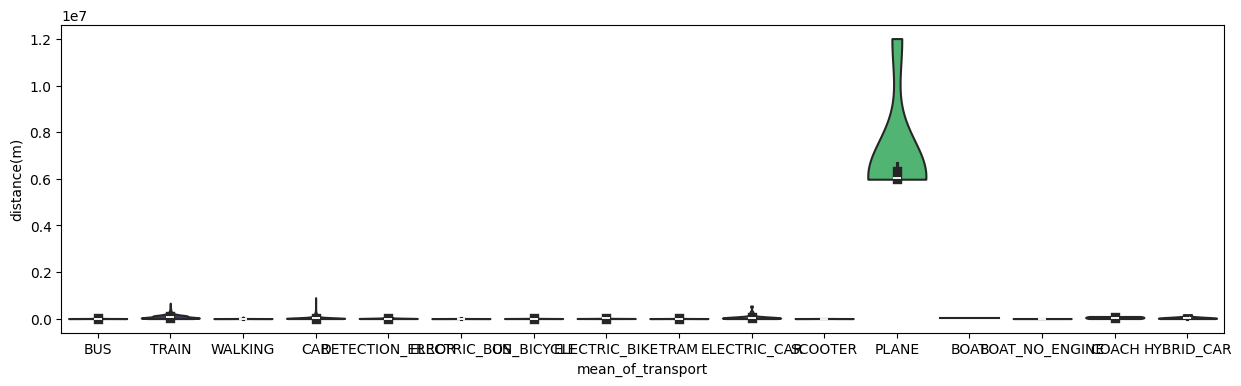

In [17]:
# Plot as violin plot
plt.figure(figsize=(15, 4))
sns.violinplot(x='mean_of_transport', y='distance(m)', data=dist_per_day, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis')

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_46157/1446108219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_of_transport', y='distance(m)', data=long, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Long distance
/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_46157/1446108219.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_of_transport', y='distance(m)', data=short, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Short distance


<Axes: xlabel='mean_of_transport', ylabel='distance(m)'>

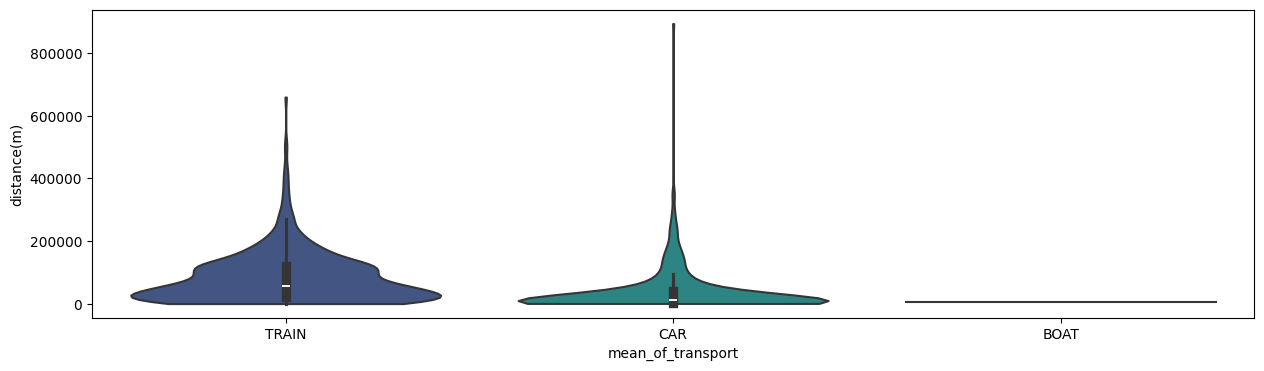

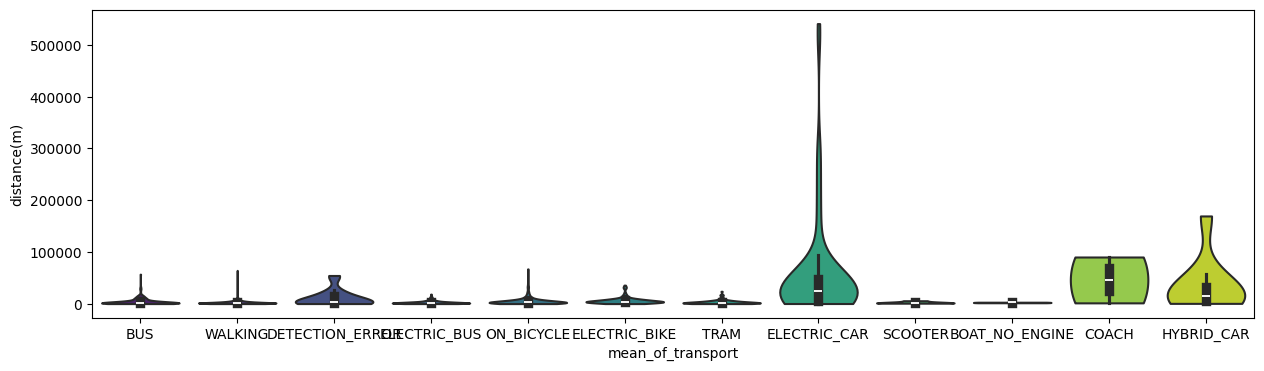

In [18]:
# Separate car, train, boat from the rest and plot
long = dist_per_day[dist_per_day['mean_of_transport'].isin(['CAR', 'TRAIN', 'BOAT'])]
short = dist_per_day[~dist_per_day['mean_of_transport'].isin(['CAR', 'TRAIN', 'BOAT', 'PLANE'])]

plt.figure(figsize=(15, 4))
sns.violinplot(x='mean_of_transport', y='distance(m)', data=long, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Long distance

plt.figure(figsize=(15, 4))
sns.violinplot(x='mean_of_transport', y='distance(m)', data=short, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Short distance

## Create a visualization of the covered routes

In [19]:
## Get a coordinate from a geohash, adding a small random offset to avoid overlapping
def geohash_to_coordinate(geohash):
    try:
        lat, lon = geolib.decode(geohash)
        #lat = float(lat) + 0.00000001#(random.random() - 0.5) * 0.00000001
        #lon = float(lon) + 0.00000001#(random.random() - 0.5) * 0.00000001
        return [float(lat), float(lon)]
    except:
        return [float(0.0), float(0.0)]

In [20]:
## Draw a path from start_geohash to end_geohash on a folium map
def draw_path(start_geohash, end_geohash, mean_of_transport, map, weight=1, tooltip=None):
    ## Give a different color to each mean of transport
    colors = {
        'WALKING': '#7FC97F',
        'ON_BICYCLE': '#BDAED4',
        'ELECTRIC_BIKE': '#BDAED4',
        'SCOOTER': '#BDAED4',
        'TRAIN': '#FDBF85',
        'BUS': '#FFFF99',
        'ELECTRIC_BUS': '#FFFF99',
        'CAR': '#386CB0',
        'ELECTRIC_CAR': '#386CB0',
        'HYBRID_CAR': '#386CB0',
        'TRAM': '#F0027F',
        'PLANE': '#BE5B17',
        'BOAT': '#BE5B17',
        'BOAT_NO_ENGINE': '#BE5B17',
        'DETECTION_ERROR': '#000000',
        'COACH': '#FFFF99',
    }

    try:
        start_coord = geohash_to_coordinate(start_geohash)
        end_coord = geohash_to_coordinate(end_geohash)

        # Add a small offset to avoid overlapping
        start_coord[0] += (random.random() - 0.5) * 0.001
        start_coord[1] += (random.random() - 0.5) * 0.001
        end_coord[0] += (random.random() - 0.5) * 0.001
        end_coord[1] += (random.random() - 0.5) * 0.001

        #arc_drawer.draw_arc(map, start_coord[0], start_coord[1], end_coord[0], end_coord[1], color=colors[mean_of_transport], weight = weight)

        folium.PolyLine(locations=[start_coord, end_coord], color=colors[mean_of_transport], weight=weight, tooltip=tooltip).add_to(map)
    except Exception as e:
        print(e)
        print(start_geohash, end_geohash)


In [59]:
## Create the actual folium map
m = folium.Map(location=[46.9446011, 7.4143311], zoom_start=6, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')

# Count the number of movements with the same combination of start_geohash and end_geohash (or vice-versa)
df['start_end_geohash'] = df['start_geohash'] + df['end_geohash']
df['end_start_geohash'] = df['end_geohash'] + df['start_geohash']

## Get the number of movements with the same combination of start_geohash and end_geohash (or vice-versa)
start_end = df['start_end_geohash'].value_counts()
end_start = df['end_start_geohash'].value_counts()

## Create a list with the sum of the two previous lists, when the index is the same
combined = {}

for index, row in start_end.items():
    if index in end_start:
        combined[index] = row + end_start[index]
    else:
        combined[index] = row

for index, row in end_start.items():
    if index not in combined:
        combined[index] = row

## Convert combined to series
combined = pd.Series(combined)

# Log scaling
combined = combined.apply(lambda x: math.log(x) + 1)

# Draw path for each movement in start_end
for index, row in combined.items():
    start_geohash = index[0:len(index)//2]
    end_geohash = index[len(index)//2:len(index)] 

    try:
        mean_of_transport = df.loc[(df['start_geohash'] == start_geohash) & (df['end_geohash'] == end_geohash), 'mean_of_transport'].iloc[0]
    except:
        mean_of_transport = df.loc[(df['end_geohash'] == start_geohash) & (df['start_geohash'] == end_geohash), 'mean_of_transport'].iloc[0]

    draw_path(start_geohash, end_geohash, mean_of_transport, m, weight = row/max(combined)*7)

## Draw a path for each movement
#for index, row in df.iterrows():
#    draw_path(row['start_geohash'], row['end_geohash'], row['mean_of_transport'], m)

## Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

## Save the map as an html file
m.save('maps/paths_map.html')


## Create a heatmap of the locations visited

In [22]:
## Extract from df a list of all start_geohashes and end_geohashes
geohashes = list(df['start_geohash']) + list(df['end_geohash'])
len(geohashes)

1498

In [23]:
# If we want, we can remove some characters from the end of each geohash to reduce the precision
geohashes = [geohash[:-1] for geohash in geohashes]

In [24]:
# Convert the list of geohashes to a dataframe
geohashes_df = gpd.GeoDataFrame(geohashes, columns=['geohash'])

## Convert the list of geohashes to a geoJSON object


In [25]:
## Convert geohashes to a heatmap in geojson format
def geohashes_to_heatmap(df):
    # Get the distinct geohashes and their counts from the dataframe
    geohashes = df['geohash'].value_counts()

    # Get the maximum count of any geohash
    max_count = math.log(geohashes.max())

    # Convert the geohashes to a list of lists, each containing the geohash and its count
    geohashes = [[geohash, count] for geohash, count in zip(geohashes.index, geohashes)]
    
    # Create a color scale for the heatmap
    color_scale = linear.RdYlBu_10.scale(1, max_count)

    # Convert geohashes to features for geoJSON
    features = []

    for geohash in geohashes:
        # Get the bounds of the geohash
        bounds = geolib.bounds(geohash[0])
        color = color_scale(math.log(geohash[1]))

        # Create a feature for the geohash
        features.append({
            "type": "Feature",
            "properties": {
                "id": geohash[0],
                "fillColor": color,
                "fillOpacity": 0.6,
                "stroke": False
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bounds.sw.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.sw.lat]
                ]]
            },
        })

    # Convert the geohashes to a heatmap in geojson format
    return {
        "type" : "FeatureCollection",
        "features": features
    }

In [26]:
# Convert the geohashes to a heatmap in geojson format
heatmap = geohashes_to_heatmap(geohashes_df)

# Save GeoJSON with double quotes
with open('results/heatmap.geojson', 'w') as f:
    json.dump(heatmap, f)

In [27]:
# Visualize as a heatmap using Folium
# Create a folium map centered at an initial location
def create_map(geojson, mapname, legend=None):
    m = folium.Map(location=[46.9446011, 7.4143311],zoom_start=6, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')

    # Define a style function to set the color of the polygon
    def style_function(feature):
        return {
            'fillColor': feature["properties"]["fillColor"],  # Change this to the desired color
            'stroke': feature["properties"]["stroke"],
            'fillOpacity': feature["properties"]["fillOpacity"],
        }

    # Add GeoJSON data to the map with the style function
    folium.GeoJson(
        geojson,
        name='Polygon Layer',
        style_function=style_function,
    ).add_to(m)

    # Add Layer Control to the map
    folium.LayerControl().add_to(m)

    if legend:
        m.get_root().html.add_child(folium.Element(legend))

    # Save or display the map
    m.save("maps/"+mapname)


In [28]:
create_map(heatmap, "heatmap.html")

In [29]:
!open -a Arc maps/heatmap.html

## Get the map of the most used vehicles

In [ ]:
## Get the list of geohashes with the corresponding mean of transport
geohashes = df[['start_geohash', 'mean_of_transport']].copy()
## Append the end_geohashes to the list of geohashes
geohashes = gpd.GeoDataFrame(pd.concat([geohashes, df[['end_geohash', 'mean_of_transport']]]))
## Merge start_geohashes and end_geohashes into a single column
geohashes['geohash'] = geohashes['start_geohash'].combine_first(geohashes['end_geohash'])
## Remove the start_geohashes and end_geohashes columns
geohashes = geohashes[['geohash', 'mean_of_transport']]

## Reduce precision of geohashes
geohashes['geohash'] = geohashes['geohash'] #.str[:-1]

geohashes

In [ ]:
## Find the mean of transport that occurs the more often for each geohash and keep only the first one (the most used)
geohashes_df = gpd.GeoDataFrame(geohashes, columns=['geohash', 'mean_of_transport'])
# Get the count of the mean of transport for each geohash
geohashes_df = geohashes_df.groupby(['geohash', 'mean_of_transport']).size().reset_index(name='counts')
# For each geohash, keep only the mean of transport that occurs the most often
geohashes_df = geohashes_df.sort_values('counts', ascending=False).drop_duplicates(['geohash'])
# Remove the counts column
#geohashes_df = geohashes_df[['geohash', 'mean_of_transport']]
geohashes_df

In [60]:
## Convert geohashes to a heatmap in geojson format
def heatmap_mot(df):
    ## Give a different color to each mean of transport
    colors = {
        'WALKING': '#7FC97F',
        'ON_BICYCLE': '#BDAED4',
        'ELECTRIC_BIKE': '#BDAED4',
        'SCOOTER': '#BDAED4',
        'TRAIN': '#FDBF85',
        'BUS': '#FFFF99',
        'ELECTRIC_BUS': '#FFFF99',
        'CAR': '#386CB0',
        'ELECTRIC_CAR': '#386CB0',
        'HYBRID_CAR': '#386CB0',
        'TRAM': '#F0027F',
        'PLANE': '#BE5B17',
        'BOAT': '#BE5B17'
    }

    # Convert geohashes to features for geoJSON
    features = []

    for geohash in df:
        # Get the bounds of the geohash
        bounds = geolib.bounds(geohash[0])
        color = colors[geohash[1]]

        # Create a feature for the geohash
        features.append({
            "type": "Feature",
            "properties": {
                "id": geohash[0],
                "fillColor": color,
                "fillOpacity": 0.8,
                "stroke": False
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bounds.sw.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.sw.lat]
                ]]
            },
        })

    # Convert the geohashes to a heatmap in geojson format
    return {
        "type" : "FeatureCollection",
        "features": features
    }

In [ ]:
# Convert the means of transport to a heatmap in geojson format
heatmap = heatmap_mot(geohashes_df.values)

# Save GeoJSON with double quotes
with open('results/heatmap_mot.geojson', 'w') as f:
    json.dump(heatmap, f)

In [97]:
create_map(heatmap, "heatmap_mot.html", legend_html)

In [98]:
!open -a Arc maps/heatmap_mot.html

## Get the map of the movements (start to end point)

In [27]:
# Now we should create a map with lines between the geohashes, with the color of the line corresponding to the mean of transport
# We should also create a legend for the map

## Create the actual folium map
m = folium.Map(location=[46.9446011, 7.4143311], zoom_start=8, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')
# Draw a path for each movement
for index, row in df.iterrows():
    draw_path(row['start_geohash'], row['end_geohash'], row['mean_of_transport'], m, weight = 2, tooltip=row['participant_id'])


## Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

## Save the map as an html file
m.save('maps/paths_map_mot.html')

!open -a Arc maps/paths_map_mot.html

/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


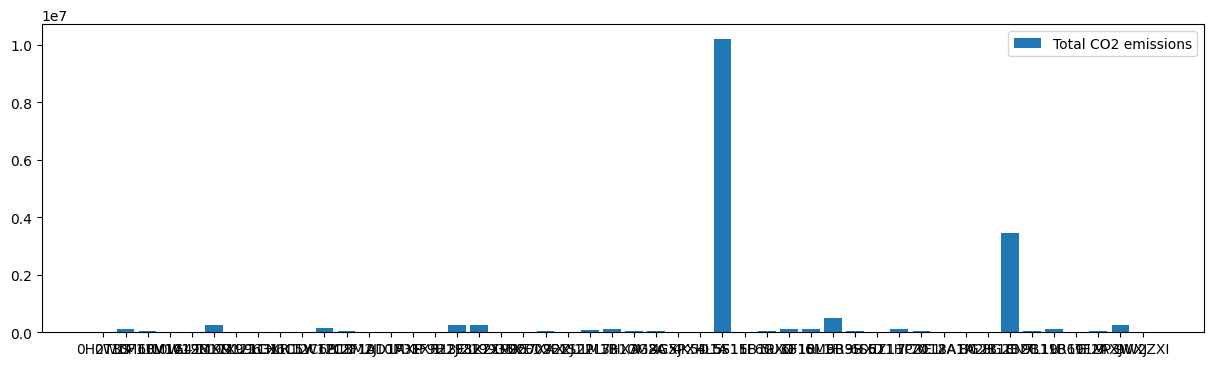

In [60]:
# Compute the total CO2 emissions for each person
df_co2 = df.groupby('participant_id')['gCO2'].sum()

# Plot the total CO2 emissions for each person in a bar plot, together with the average CO2 emissions per km in different bars
plt.figure(figsize=(15, 4))
plt.bar(df_co2.index, df_co2, label='Total CO2 emissions')
plt.legend()
plt.show()

/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


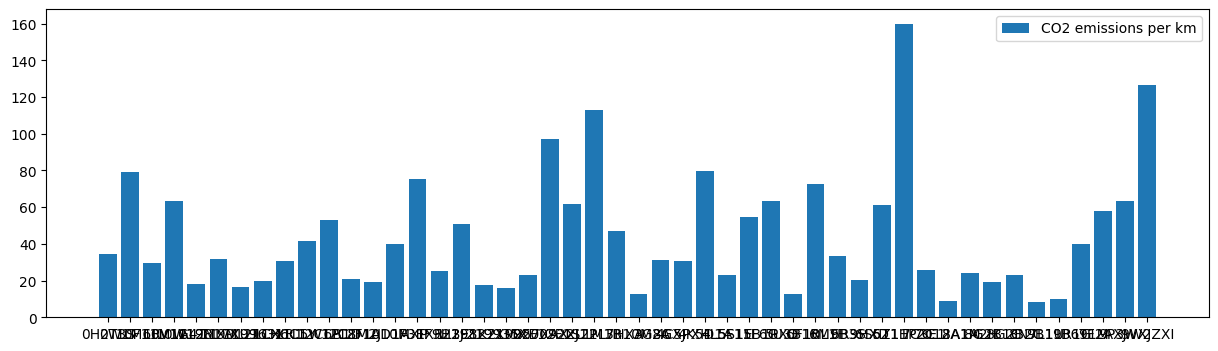

In [61]:
# Compute the emissions per km for each person
df['gCO2_per_km'] = df['gCO2'] / df['distance(m)'] * 1000
df['gCO2_per_km'] = df['gCO2_per_km'].replace([np.inf, -np.inf], np.nan)

# Plot the emissions per km for each person in a bar plot
df_co2_per_km = df.groupby('participant_id')['gCO2_per_km'].mean()
plt.figure(figsize=(15, 4))
plt.bar(df_co2_per_km.index, df_co2_per_km, label='CO2 emissions per km')
plt.legend()
plt.show()


/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


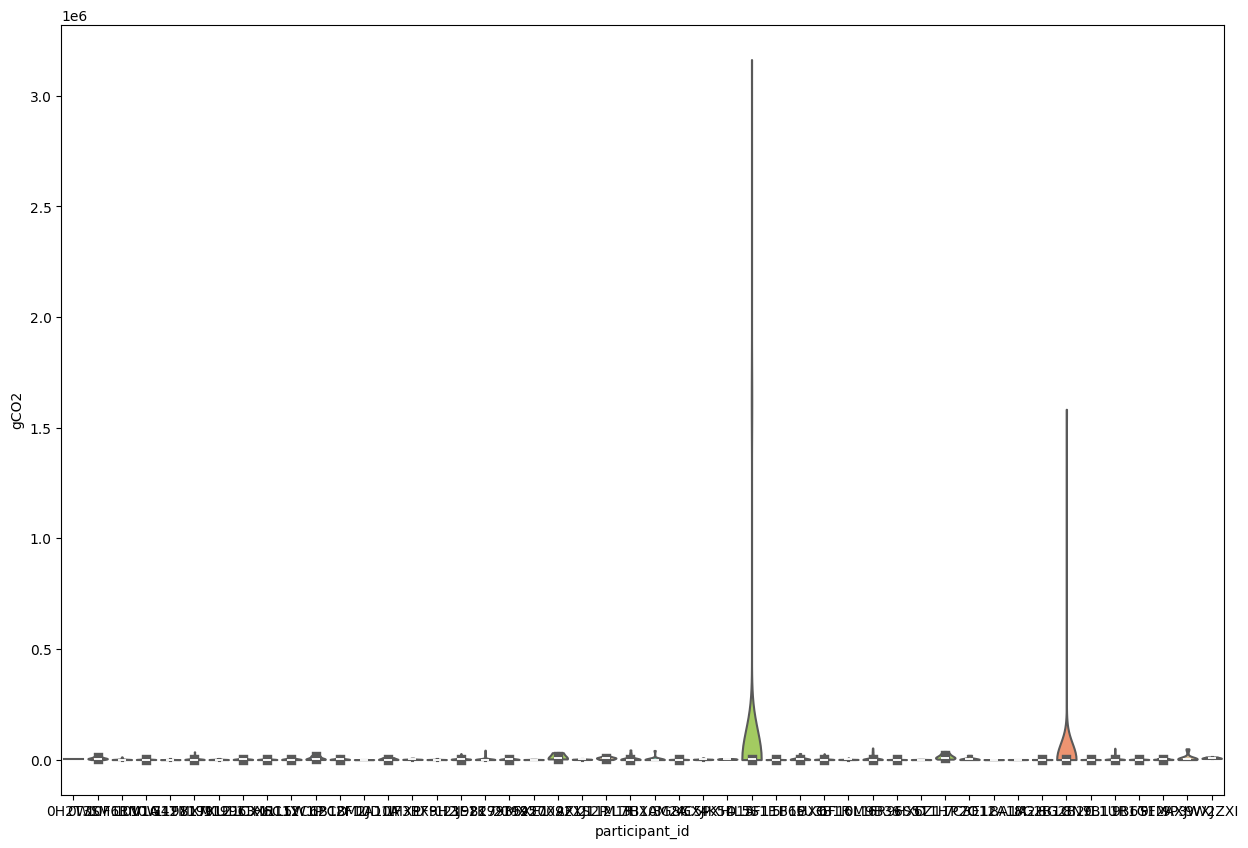

In [62]:
# Compute the emissions per day (using start time) for each person
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date
df_co2_per_day = df.groupby(['participant_id', 'day'])['gCO2'].sum()

# Plot emissions per day for each person in a violin plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='participant_id', y='gCO2', data=df_co2_per_day.reset_index(), inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='Set2', hue='participant_id')
plt.show()

In [21]:
# Reduce precision of geohash by 1 character for the rows where we covered a long distance (more than 10 km)
df['start_geohash'] = df.apply(lambda x: x['start_geohash'][:-1] if x['distance(m)'] > 10000 else x['start_geohash'], axis=1)
df['end_geohash'] = df.apply(lambda x: x['end_geohash'][:-1] if x['distance(m)'] > 10000 else x['end_geohash'], axis=1)

In [22]:
# Define colors for each mode of transport
alpha = 128
colors = {
    'WALKING': [70, 130, 180, alpha],      # Steel Blue (distinct blue for walking)
    'ON_BICYCLE': [100, 149, 237, alpha],  # Cornflower Blue (different blue for bike)
    'ELECTRIC_BIKE': [100, 149, 237, alpha],
    'SCOOTER': [100, 149, 237, alpha],
    'TRAIN': [0, 191, 255, alpha],         # Deep Sky Blue (different blue for train)
    'BUS': [255, 182, 193, alpha],         # Light Pink (distinct from car/tram/plane)
    'ELECTRIC_BUS': [255, 182, 193, alpha],
    'COACH': [255, 182, 193, alpha],
    'CAR': [255, 105, 180, alpha],        # Hot Pink (distinct for car)
    'ELECTRIC_CAR': [255, 105, 180, alpha],
    'HYBRID_CAR': [255, 105, 180, alpha],
    'TRAM': [255, 160, 122, alpha],       # Light Salmon Pink (distinct from bus and car)
    'PLANE': [255, 105, 180, alpha],      # Hot Pink (same as car, but could be changed if needed)
    'BOAT': [255, 105, 180, alpha],       # Hot Pink
    'BOAT_NO_ENGINE': [255, 105, 180, alpha],
    'DETECTION_ERROR': [0, 0, 0, alpha],  # Black
}

In [23]:
df.size

98153

In [24]:
# IF two movements from the same user have the same start geohash and start time, we should merge them into a single movement (keep the one with the highest distance)
df['start_time'] = pd.to_datetime(df['start_time'])

# Group by participant_id, start_geohash, start_time and maximum distance, keep all the other data from the row with the maxium distance
df = df.groupby(['participant_id', 'start_geohash', 'start_time'])['distance(m)'].max().reset_index().merge(df, on=['participant_id', 'start_geohash', 'start_time', 'distance(m)'])

In [25]:
df.size

72622

In [30]:
# Merge consecutive movements with the same mode of transport
def merge_consecutive_movements(df, time_min):
    # Group movements by participant and mode of transport, and sort by start time
    df = df.sort_values(['participant_id', 'mean_of_transport', 'start_time'])

    # Calculate time difference between end time of one movement and start time of the next
    df['prev_end_time'] = df.groupby(['participant_id', 'mean_of_transport'])['end_time'].shift()
    df['time_diff'] = (df['start_time'] - pd.to_datetime(df['prev_end_time'])).dt.total_seconds() / 60

    # Create a new column to store the group number
    df['group'] = (df['time_diff'] > time_min).cumsum()

    # Group by participant, mode of transport and group number, and calculate the start and end time of the group
    df = df.groupby(['participant_id', 'mean_of_transport', 'group']).agg(
        start_time=('start_time', 'first'),
        end_time=('end_time', 'last'),
        start_geohash=('start_geohash', 'first'),
        end_geohash=('end_geohash', 'last'),
        distance=('distance(m)', 'sum'),
        gCO2=('gCO2', 'sum')
    ).reset_index()

In [31]:
merge_consecutive_movements(df, 60)

In [32]:
# Get only the rows with distance smaller than 10km
'''
df_copy = df.copy()
df = df[df['distance(m)'] < 10000]
'''

"\ndf_copy = df.copy()\ndf = df[df['distance(m)'] < 10000]\n"

In [ ]:
# Get only the rows with distance bigger than 10km

df = df_copy.copy()
df_copy = df.copy()
df = df[df['distance(m)'] > 10000]


In [34]:
# Process all paths in one step
df['start_coords'] = df['start_geohash'].apply(geohash_to_coordinate)
df['end_coords'] = df['end_geohash'].apply(geohash_to_coordinate)

# Add slight offsets to avoid overlaps
df['start_coords'] = df['start_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])
df['end_coords'] = df['end_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])

'''
# Add random height to the start and end coordinates
df['start_coords'] = df['start_coords'].apply(lambda x: [x[0], x[1], random.randint(10000, 20000)])
df['end_coords'] = df['end_coords'].apply(lambda x: [x[0], x[1], random.randint(10000, 20000)])
'''

# Create data list for Pydeck
path_data = df[['start_coords', 'end_coords', 'mean_of_transport', 'participant_id']].copy()
path_data['color'] = path_data['mean_of_transport'].apply(lambda x: colors.get(x, [0, 0, 0])) # Default black for unknown transport
path_data['color_start'] = path_data['color'].apply(lambda x: [xi * 0.7 for xi in x])  # Slightly darker starting color

# Pydeck ArcLayer (Curved Lines)
layer = pdk.Layer(
    "ArcLayer",
    data=path_data,
    get_source_position="start_coords",
    get_target_position="end_coords",
    get_source_color="color_start",
    get_target_color="color",
    get_color="color", # for linelayer
    get_width=1,
    get_height = 1, # Change the height of the arc, negative values make it go down
    pickable=True,
    auto_highlight=True,
)

# Define map view
view_state = pdk.ViewState(
    latitude=df['start_coords'].iloc[0][1],  # Center on first start point
    longitude=df['start_coords'].iloc[0][0],
    zoom=8,
    pitch=80,  # Adds some 3D depth for better arc visibility
)

# Render and save
deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{participant_id} - {mean_of_transport}"})
deck.to_html("maps/paths_map_mot.html")

# Open in browser
!open -a Arc maps/paths_map_mot.html

In [71]:
# Group trips that were from the same start and end geohash and vehicle, to reduce clutter
grouped = df.groupby(['start_geohash', 'end_geohash', 'mean_of_transport']).size().reset_index(name='counts')

# Get coordinates from geohashes
grouped['start_coords'] = grouped['start_geohash'].apply(geohash_to_coordinate)
grouped['end_coords'] = grouped['end_geohash'].apply(geohash_to_coordinate)

# Add slight offsets to avoid overlaps
grouped['start_coords'] = grouped['start_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])
grouped['end_coords'] = grouped['end_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])

# Create data list for Pydeck
path_data = grouped[['start_coords', 'end_coords', 'mean_of_transport', 'counts']].copy()
path_data['color'] = path_data['mean_of_transport'].apply(lambda x: colors.get(x, [0, 0, 0])) # Default black for unknown transport
path_data['color_start'] = path_data['color'].apply(lambda x: [xi * 0.7 for xi in x])  # Slightly darker starting color

# Get maxium count for scaling - then scale with a log scale, with minimum 1 width and maximum 5
max_count = path_data['counts'].max()
path_data['width'] = path_data['counts'].apply(lambda x: max(1, min(5, math.log(x + 1) / math.log(max_count + 1) * 5)))

# Pydeck ArcLayer (Curved Lines)
layer = pdk.Layer(
    "ArcLayer",
    data=path_data,
    get_source_position="start_coords",
    get_target_position="end_coords",
    get_source_color="color_start",
    get_target_color="color",
    get_width="width",  # Scale width based on counts
    pickable=True,
    auto_highlight=True,
)

# Define map view
view_state = pdk.ViewState(
    latitude=df['start_coords'].iloc[0][1],  # Center on first start point
    longitude=df['start_coords'].iloc[0][0],
    zoom=8,
    pitch=30,  # Adds some 3D depth for better arc visibility
)

# Render and  save
deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{mean_of_transport} - {counts}"})
deck.to_html("maps/paths_map_mot_grouped.html")

# Open in browser
!open -a Arc maps/paths_map_mot_grouped.html

In [72]:
# Print distances by train, average, median and standard deviation
train = df[df['mean_of_transport'] == 'TRAIN']['distance(m)']

print('Train distances:')
print('Average:', train.mean())
print('Median:', train.median())

print(train.describe())

print(train)

Train distances:
Average: 35832.89820359281
Median: 26769.0
count      1169.000000
mean      35832.898204
std       39685.264692
min         264.000000
25%        7643.000000
50%       26769.000000
75%       48681.000000
max      311709.000000
Name: distance(m), dtype: float64
0        49134
4        19710
8        20679
28       16209
97      109620
         ...  
6335     23989
6337     57321
6354     20223
6433     66371
6437     29339
Name: distance(m), Length: 1169, dtype: int64
